# U-net type encoder-decoder convolutional neural network

## Create a U-net type encoder-decoder CNN in Keras

### Import required Python libraries



In [ ]:

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.layers import concatenate, UpSampling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
import cv2
from skimage import transform, io

from skimage.transform import rescale, resize, downscale_local_mean


### Import, process, and shape the dataset

In [ ]:
# mount google drive to virtual machine using an authorization code

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.listdir

In [ ]:
Ftest = '/content/drive/My Drive/Colab Notebooks/DLOI/week9/facades/test'
Ftrain = '/content/drive/My Drive/Colab Notebooks/DLOI/week9/facades/train'
Fval = '/content/drive/My Drive/Colab Notebooks/DLOI/week9/facades/val'

test = [os.path.join(root, filename)
          for root, dirs, files in os.walk(Ftest)
          for filename in files]

train = [os.path.join(root, filename)
          for root, dirs, files in os.walk(Ftrain)
          for filename in files]

val = [os.path.join(root, filename)
          for root, dirs, files in os.walk(Fval)
          for filename in files]


print('Test images: ',len(test))
print('Train images: ',len(train))
print('Validation images: ',len(val))

Test images:  106
Train images:  400
Validation images:  100


In [ ]:
test_images = []
for img in test:
  test_images.append(resize(io.imread(img),(256,512)))

In [ ]:
train_images = []
for img in train:
  train_images.append(resize(io.imread(img),(256,512)))

In [ ]:
train_GT = np.array(train_images)[:,:,:256,:]
train_rect = np.array(train_images)[:,:,256:,:]

print(np.shape(train_GT))
print(np.shape(train_rect))

(400, 256, 256, 3)
(400, 256, 256, 3)


In [ ]:
test_GT = np.array(test_images)[:,:,:256,:]
test_rect = np.array(test_images)[:,:,256:,:]

print(np.shape(test_GT))
print(np.shape(test_rect))

(106, 256, 256, 3)
(106, 256, 256, 3)


(-0.5, 255.5, 255.5, -0.5)

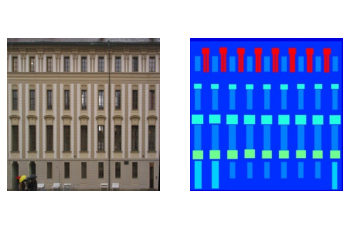

In [ ]:
plt.subplot(121);plt.imshow(test_GT[4])
plt.axis('equal')
plt.axis('off')
plt.subplot(122);plt.imshow(test_rect[4])
plt.axis('equal')
plt.axis('off')

* processing and shaping data

input_train :  (400, 256, 256, 3)
output_train :  (400, 256, 256, 3)
input_test :  (106, 256, 256, 3)
output_test :  (106, 256, 256, 3)

* plot example from training set

item_id :  5



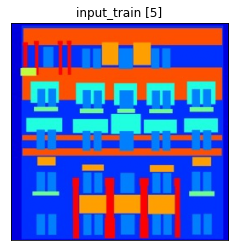

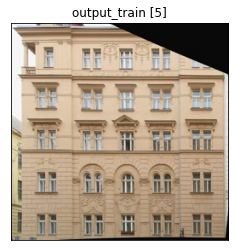

In [ ]:
output_train = train_GT
input_train = train_rect
output_test = test_GT
input_test = test_rect

#input_train= input_train.reshape(input_train.shape[0], 28, 28, 1)  # add an extra dimension to array
#output_train= output_train.reshape(output_train.shape[0], 28, 28, 1)
#input_test= input_test.reshape(input_test.shape[0], 28, 28, 1)
#output_test= output_test.reshape(output_test.shape[0], 28, 28, 1)

print('* processing and shaping data')
print()
print('input_train : ', input_train.shape)
print('output_train : ', output_train.shape)
print('input_test : ', input_test.shape)
print('output_test : ', output_test.shape)
print()

# plot example

item_id = 5

print('* plot example from training set')
print()
print('item_id : ', item_id)
print()

plt.imshow(input_train[item_id])
plt.title('input_train [' + str(item_id) + ']')
plt.grid(None)
plt.xticks([])
plt.yticks([])
plt.show()

plt.imshow(output_train[item_id])
plt.title('output_train [' + str(item_id) + ']')
plt.grid(None)
plt.xticks([])
plt.yticks([])
plt.show()

### Define the network hyperparameters

In [ ]:
optimizer_type = Adam(lr=2e-4,beta_1=0.5)  # optimisation algorithm: Adam 
loss = 'mean_absolute_error'  # loss (cost) function to be minimised by the optimiser
metrics = ['mean_absolute_error']  # network accuracy metric to be determined after each epoch
validtrain_split_ratio = 0.2  # % of the seen dataset to be put aside for validation, rest is for training
max_epochs = 20  # maxmimum number of epochs to be iterated
batch_size = 10   # batch size for the training data set
batch_shuffle = True   # shuffle the training data prior to batching before each epoch


### Define the network architecture

* using the Keras' *functional* model


In [ ]:
input_shape = (256, 256, 3)
inputs = Input(shape=input_shape)

# encoder section

down7 = Conv2D(64, (4, 4), strides=(2,2), padding='same')(inputs)
#down7 = BatchNormalization()(down7)
down7 = Activation('relu')(down7)

down6 = Conv2D(128, (4, 4), strides=(2,2), padding='same')(down7)
down6 = BatchNormalization()(down6)
down6 = Activation('relu')(down6)

down5 = Conv2D(256, (4, 4), strides=(2,2), padding='same')(down6)
down5 = BatchNormalization()(down5)
down5 = Activation('relu')(down5)

down4 = Conv2D(512, (4, 4), strides=(2,2), padding='same')(down5)
down4 = BatchNormalization()(down4)
down4 = Activation('relu')(down4)

down3 = Conv2D(512, (4, 4), strides=(2,2), padding='same')(down4)
down3 = BatchNormalization()(down3)
down3 = Activation('relu')(down3)

down2 = Conv2D(512, (4, 4), strides=(2,2), padding='same')(down3)
down2 = BatchNormalization()(down2)
down2 = Activation('relu')(down2)

down1 = Conv2D(512, (4, 4), strides=(2,2), padding='same')(down2)
down1 = BatchNormalization()(down1)
down1 = Activation('relu')(down1)

center = Conv2D(512, (4, 4), strides=(2,2), padding='same')(down1)
#center = BatchNormalization()(center)
center = Activation('relu')(center)

up1 = UpSampling2D((2, 2))(center)
up1 = BatchNormalization()(up1)
up1 = concatenate([down1, up1], axis=3)
up1 = Conv2D(512, (4, 4), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)


up2 = UpSampling2D((2, 2))(up1)
up2 = BatchNormalization()(up2)
up2 = concatenate([down2, up2], axis=3)
up2 = Conv2D(512, (4, 4), padding='same')(up2)
up2 = BatchNormalization()(up2)
up2 = Activation('relu')(up2)


up3 = UpSampling2D((2, 2))(up2)
up3 = BatchNormalization()(up3)
up3 = concatenate([down3, up3], axis=3)
up3 = Conv2D(512, (4, 4), padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Activation('relu')(up3)


up4 = UpSampling2D((2, 2))(up3)
up4 = BatchNormalization()(up4)
up4 = concatenate([down4, up4], axis=3)
up4 = Conv2D(512, (4, 4), padding='same')(up4)
up4 = BatchNormalization()(up4)
up4 = Activation('relu')(up4)


up5 = UpSampling2D((2, 2))(up4)
up5 = BatchNormalization()(up5)
up5 = concatenate([down5, up5], axis=3)
up5 = Conv2D(256, (4, 4), padding='same')(up5)
up5 = BatchNormalization()(up5)
up5 = Activation('relu')(up5)


up6 = UpSampling2D((2, 2))(up5)
up6 = BatchNormalization()(up6)
up6 = concatenate([down6, up6], axis=3)
up6 = Conv2D(128, (4, 4), padding='same')(up6)
up6 = BatchNormalization()(up6)
up6 = Activation('relu')(up6)


up7 = UpSampling2D((2, 2))(up6)
up7 = BatchNormalization()(up7)
up7 = concatenate([down7, up7], axis=3)
up7 = Conv2D(64, (4, 4), padding='same')(up7)
up7 = BatchNormalization()(up7)
up7 = Activation('relu')(up7)


out = UpSampling2D((2, 2))(up7)
out = Conv2D(3, (4, 4), padding='same')(out)
#outputs = BatchNormalization()(out)
outputs = Activation('sigmoid')(out)


   

### Compile the network

In [ ]:

print()
print('* Compiling the network model *')
print()

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=optimizer_type, loss=loss, metrics=metrics)

# display a summary of the compiled neural network

print(model.summary())  
print()


* Compiling the network model *

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_192 (Conv2D)             (None, 128, 128, 64) 3136        input_13[0][0]                   
__________________________________________________________________________________________________
activation_192 (Activation)     (None, 128, 128, 64) 0           conv2d_192[0][0]                 
__________________________________________________________________________________________________
conv2d_193 (Conv2D)             (None, 64, 64, 128)  131200      activation_192[0][0]             
_________________________________________________________

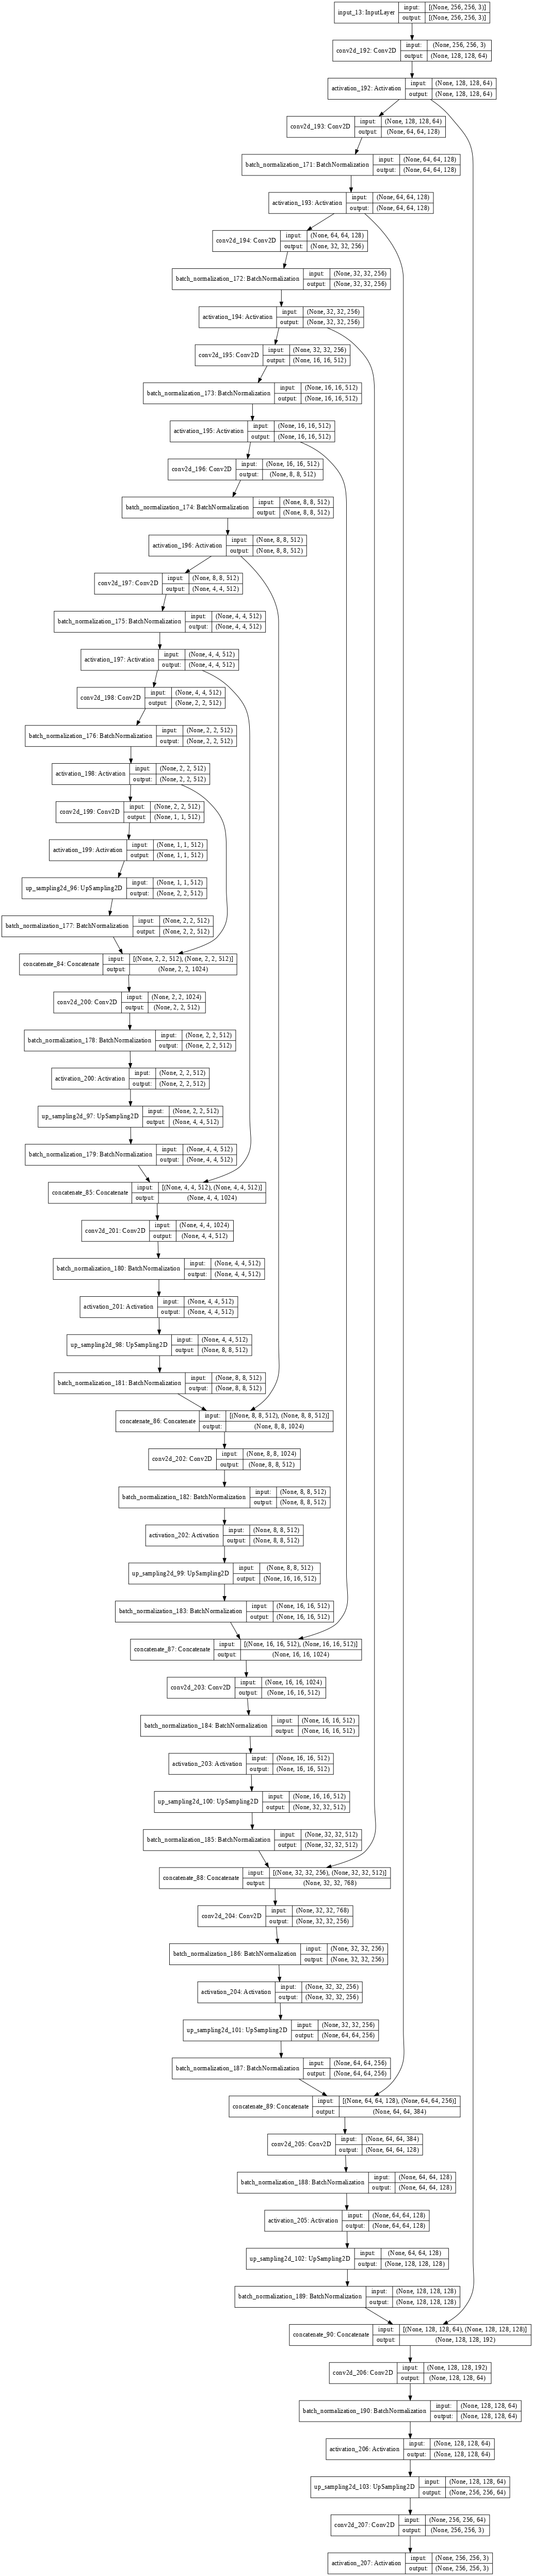

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

### Train the neural network with the training dataset

In [ ]:
print('* Training the compiled network *')
print()

history = model.fit(input_train, output_train, \
                    batch_size=batch_size, \
                    epochs=max_epochs, \
                    validation_split=validtrain_split_ratio, \
                    shuffle=batch_shuffle)

print()
print('Training completed')
print()

* Training the compiled network *

Epoch 1/20
32/32 [==============================] - 33s 955ms/step - loss: 0.2080 - mean_absolute_error: 0.2080 - val_loss: 0.1941 - val_mean_absolute_error: 0.1941
Epoch 2/20
32/32 [==============================] - 30s 939ms/step - loss: 0.1703 - mean_absolute_error: 0.1703 - val_loss: 0.1901 - val_mean_absolute_error: 0.1901
Epoch 3/20
32/32 [==============================] - 30s 939ms/step - loss: 0.1636 - mean_absolute_error: 0.1636 - val_loss: 0.1892 - val_mean_absolute_error: 0.1892
Epoch 4/20
32/32 [==============================] - 30s 937ms/step - loss: 0.1592 - mean_absolute_error: 0.1592 - val_loss: 0.1872 - val_mean_absolute_error: 0.1872
Epoch 5/20
32/32 [==============================] - 30s 937ms/step - loss: 0.1573 - mean_absolute_error: 0.1573 - val_loss: 0.1891 - val_mean_absolute_error: 0.1891
Epoch 6/20
32/32 [==============================] - 30s 936ms/step - loss: 0.1516 - mean_absolute_error: 0.1516 - val_loss: 0.2041 - val_mea

### Plot the training history of the network

### Predict the output of a given input

* plot example from test set

item_id :  3



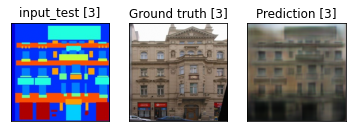

* plot example from test set

item_id :  8



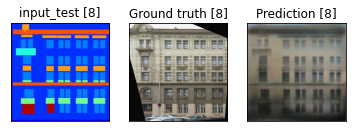

* plot example from test set

item_id :  19



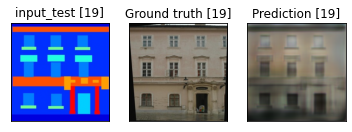

* plot example from test set

item_id :  56



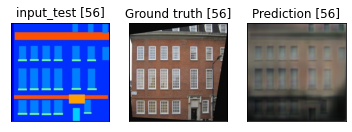

In [ ]:

for item_id in [3,8,19,56]:

  print('* plot example from test set')
  print()
  print('item_id : ', item_id)
  print()

  plt.subplot(1,3,1);plt.imshow(input_test[item_id])
  plt.title('input_test [' + str(item_id) + ']')
  plt.grid(None)
  plt.xticks([])
  plt.yticks([])
  #plt.show()

  plt.subplot(1,3,2);plt.imshow(output_test[item_id])
  plt.title('Ground truth [' + str(item_id) + ']')
  plt.grid(None)
  plt.xticks([])
  plt.yticks([])
  #plt.show()

  input_predict = np.zeros(shape=(1, 256, 256, 3))  # create numpy array of required dimensions for network input
  input_predict[0, :, :, :] = input_test[item_id, :, :, :]  # reshaping test input image
  output_predict = model.predict(input_predict)
  #print(np.shape(output_predict[0]))
  outimage=(output_predict[0])
  plt.subplot(1,3,3);plt.imshow((255*output_predict[0]).astype('uint8'))
  plt.title('Prediction [' + str(item_id) + ']')
  plt.grid(None)
  plt.xticks([])
  plt.yticks([])
  plt.show()

## 2: removing skip connections

In [ ]:
input_shape = (256, 256, 3)
inputs = Input(shape=input_shape)

# encoder section

down7 = Conv2D(64, (4, 4), strides=(2,2), padding='same')(inputs)
#down7 = BatchNormalization()(down7)
down7 = Activation('relu')(down7)

down6 = Conv2D(128, (4, 4), strides=(2,2), padding='same')(down7)
down6 = BatchNormalization()(down6)
down6 = Activation('relu')(down6)

down5 = Conv2D(256, (4, 4), strides=(2,2), padding='same')(down6)
down5 = BatchNormalization()(down5)
down5 = Activation('relu')(down5)

down4 = Conv2D(512, (4, 4), strides=(2,2), padding='same')(down5)
down4 = BatchNormalization()(down4)
down4 = Activation('relu')(down4)

down3 = Conv2D(512, (4, 4), strides=(2,2), padding='same')(down4)
down3 = BatchNormalization()(down3)
down3 = Activation('relu')(down3)

down2 = Conv2D(512, (4, 4), strides=(2,2), padding='same')(down3)
down2 = BatchNormalization()(down2)
down2 = Activation('relu')(down2)

down1 = Conv2D(512, (4, 4), strides=(2,2), padding='same')(down2)
down1 = BatchNormalization()(down1)
down1 = Activation('relu')(down1)

center = Conv2D(512, (4, 4), strides=(2,2), padding='same')(down1)
#center = BatchNormalization()(center)
center = Activation('relu')(center)

up1 = UpSampling2D((2, 2))(center)
up1 = BatchNormalization()(up1)
up1 = concatenate([down1, up1], axis=3)
up1 = Conv2D(512, (4, 4), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)


up2 = UpSampling2D((2, 2))(up1)
up2 = BatchNormalization()(up2)
#up2 = concatenate([down2, up2], axis=3)
up2 = Conv2D(512, (4, 4), padding='same')(up2)
up2 = BatchNormalization()(up2)
up2 = Activation('relu')(up2)


up3 = UpSampling2D((2, 2))(up2)
up3 = BatchNormalization()(up3)
#up3 = concatenate([down3, up3], axis=3)
up3 = Conv2D(512, (4, 4), padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Activation('relu')(up3)


up4 = UpSampling2D((2, 2))(up3)
up4 = BatchNormalization()(up4)
up4 = concatenate([down4, up4], axis=3)
up4 = Conv2D(512, (4, 4), padding='same')(up4)
up4 = BatchNormalization()(up4)
up4 = Activation('relu')(up4)


up5 = UpSampling2D((2, 2))(up4)
up5 = BatchNormalization()(up5)
#up5 = concatenate([down5, up5], axis=3)
up5 = Conv2D(256, (4, 4), padding='same')(up5)
up5 = BatchNormalization()(up5)
up5 = Activation('relu')(up5)


up6 = UpSampling2D((2, 2))(up5)
up6 = BatchNormalization()(up6)
#up6 = concatenate([down6, up6], axis=3)
up6 = Conv2D(128, (4, 4), padding='same')(up6)
up6 = BatchNormalization()(up6)
up6 = Activation('relu')(up6)


up7 = UpSampling2D((2, 2))(up6)
up7 = BatchNormalization()(up7)
up7 = concatenate([down7, up7], axis=3)
up7 = Conv2D(64, (4, 4), padding='same')(up7)
up7 = BatchNormalization()(up7)
up7 = Activation('relu')(up7)


out = UpSampling2D((2, 2))(up7)
out = Conv2D(3, (4, 4), padding='same')(out)
#outputs = BatchNormalization()(out)
outputs = Activation('sigmoid')(out)


In [ ]:

print()
print('* Compiling the network model *')
print()

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=optimizer_type, loss=loss, metrics=metrics)

# display a summary of the compiled neural network

print(model.summary())  
print()


* Compiling the network model *

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_224 (Conv2D)             (None, 128, 128, 64) 3136        input_15[0][0]                   
__________________________________________________________________________________________________
activation_224 (Activation)     (None, 128, 128, 64) 0           conv2d_224[0][0]                 
__________________________________________________________________________________________________
conv2d_225 (Conv2D)             (None, 64, 64, 128)  131200      activation_224[0][0]             
_________________________________________________________

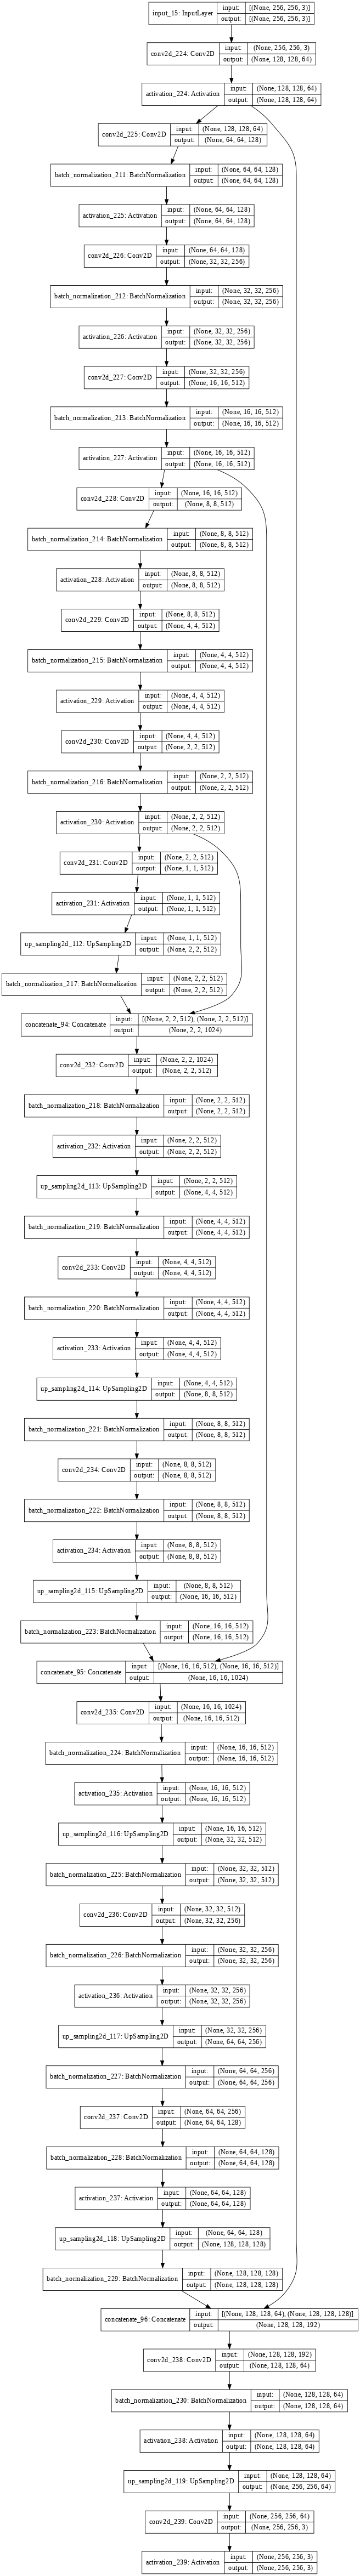

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [ ]:
print('* Training the compiled network *')
print()

history = model.fit(input_train, output_train, \
                    batch_size=batch_size, \
                    epochs=max_epochs, \
                    validation_split=validtrain_split_ratio, \
                    shuffle=batch_shuffle)

print()
print('Training completed')
print()

* Training the compiled network *

Epoch 1/20
32/32 [==============================] - 29s 812ms/step - loss: 0.2158 - mean_absolute_error: 0.2158 - val_loss: 0.3988 - val_mean_absolute_error: 0.3988
Epoch 2/20
32/32 [==============================] - 26s 806ms/step - loss: 0.1795 - mean_absolute_error: 0.1795 - val_loss: 0.2016 - val_mean_absolute_error: 0.2016
Epoch 3/20
32/32 [==============================] - 26s 809ms/step - loss: 0.1724 - mean_absolute_error: 0.1724 - val_loss: 0.1942 - val_mean_absolute_error: 0.1942
Epoch 4/20
32/32 [==============================] - 26s 809ms/step - loss: 0.1691 - mean_absolute_error: 0.1691 - val_loss: 0.1927 - val_mean_absolute_error: 0.1927
Epoch 5/20
32/32 [==============================] - 26s 809ms/step - loss: 0.1700 - mean_absolute_error: 0.1700 - val_loss: 0.1975 - val_mean_absolute_error: 0.1975
Epoch 6/20
32/32 [==============================] - 26s 809ms/step - loss: 0.1678 - mean_absolute_error: 0.1678 - val_loss: 0.1905 - val_mea

* plot example from test set

item_id :  3



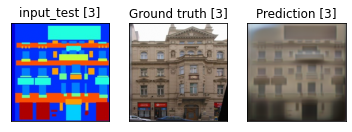

* plot example from test set

item_id :  8



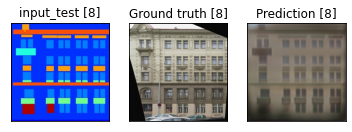

* plot example from test set

item_id :  19



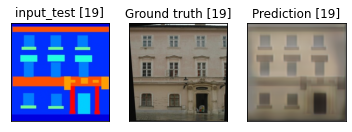

* plot example from test set

item_id :  56



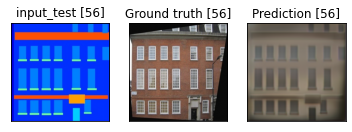

In [ ]:
for item_id in [3,8,19,56]:

  print('* plot example from test set')
  print()
  print('item_id : ', item_id)
  print()

  plt.subplot(1,3,1);plt.imshow(input_test[item_id])
  plt.title('input_test [' + str(item_id) + ']')
  plt.grid(None)
  plt.xticks([])
  plt.yticks([])
  #plt.show()

  plt.subplot(1,3,2);plt.imshow(output_test[item_id])
  plt.title('Ground truth [' + str(item_id) + ']')
  plt.grid(None)
  plt.xticks([])
  plt.yticks([])
  #plt.show()

  input_predict = np.zeros(shape=(1, 256, 256, 3))  # create numpy array of required dimensions for network input
  input_predict[0, :, :, :] = input_test[item_id, :, :, :]  # reshaping test input image
  output_predict = model.predict(input_predict)
  #print(np.shape(output_predict[0]))
  outimage=(output_predict[0])
  plt.subplot(1,3,3);plt.imshow((255*output_predict[0]).astype('uint8'))
  plt.title('Prediction [' + str(item_id) + ']')
  plt.grid(None)
  plt.xticks([])
  plt.yticks([])
  plt.show()

## 3: Downsampled imaged

In [ ]:
from skimage.color import rgb2gray
from skimage.transform import rescale, resize, downscale_local_mean

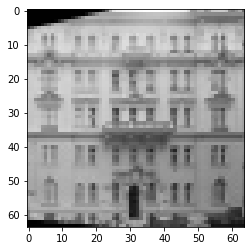

In [ ]:
gray = rgb2gray(train_GT[0])
img = downscale_local_mean(gray,(4,4))
plt.imshow(img,cmap='gray')

def transform(image):
  gray = rgb2gray(image)
  img = downscale_local_mean(gray,(4,4))
  return img

In [ ]:
output_train = np.array([transform(t) for t in train_GT])
input_train = np.array([transform(t) for t in train_rect])
output_test = np.array([transform(t) for t in test_GT])
input_test = np.array([transform(t) for t in test_rect])

In [ ]:
print(np.shape(output_train))

(400, 64, 64)


In [ ]:
optimizer_type = Adam(lr=2e-4,beta_1=0.5)  # optimisation algorithm: Adam 
loss = 'mean_absolute_error'  # loss (cost) function to be minimised by the optimiser
metrics = ['mean_absolute_error']  # network accuracy metric to be determined after each epoch
validtrain_split_ratio = 0.2  # % of the seen dataset to be put aside for validation, rest is for training
max_epochs = 20  # maxmimum number of epochs to be iterated
batch_size = 10   # batch size for the training data set
batch_shuffle = True   # shuffle the training data prior to batching before each epoch

In [ ]:
input_shape = (64, 64, 1)
inputs = Input(shape=input_shape)

# encoder section

down7 = Conv2D(16, (4, 4), strides=(2,2), padding='same')(inputs)
#down7 = BatchNormalization()(down7)
down7 = Activation('relu')(down7)

down6 = Conv2D(32, (4, 4), strides=(2,2), padding='same')(down7)
down6 = BatchNormalization()(down6)
down6 = Activation('relu')(down6)

down5 = Conv2D(64, (4, 4), strides=(2,2), padding='same')(down6)
down5 = BatchNormalization()(down5)
down5 = Activation('relu')(down5)

down4 = Conv2D(128, (4, 4), strides=(2,2), padding='same')(down5)
down4 = BatchNormalization()(down4)
down4 = Activation('relu')(down4)

down3 = Conv2D(128, (4, 4), strides=(2,2), padding='same')(down4)
down3 = BatchNormalization()(down3)
down3 = Activation('relu')(down3)

#down2 = Conv2D(512, (4, 4), strides=(2,2), padding='same')(down3)
#down2 = BatchNormalization()(down2)
#down2 = Activation('relu')(down2)

#down1 = Conv2D(512, (4, 4), strides=(2,2), padding='same')(down2)
#down1 = BatchNormalization()(down1)
#down1 = Activation('relu')(down1)

center = Conv2D(128, (4, 4), strides=(2,2), padding='same')(down3)
#center = BatchNormalization()(center)
center = Activation('relu')(center)

#up1 = UpSampling2D((2, 2))(center)
#up1 = BatchNormalization()(up1)
#up1 = concatenate([down1, up1], axis=3)
#up1 = Conv2D(512, (4, 4), padding='same')(up1)
#up1 = BatchNormalization()(up1)
#up1 = Activation('relu')(up1)


#up2 = UpSampling2D((2, 2))(up1)
#up2 = BatchNormalization()(up2)
#up2 = concatenate([down2, up2], axis=3)
#up2 = Conv2D(512, (4, 4), padding='same')(up2)
#up2 = BatchNormalization()(up2)
#up2 = Activation('relu')(up2)


up3 = UpSampling2D((2, 2))(center)
up3 = BatchNormalization()(up3)
up3 = concatenate([down3, up3], axis=3)
up3 = Conv2D(128, (4, 4), padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Activation('relu')(up3)


up4 = UpSampling2D((2, 2))(up3)
up4 = BatchNormalization()(up4)
up4 = concatenate([down4, up4], axis=3)
up4 = Conv2D(128, (4, 4), padding='same')(up4)
up4 = BatchNormalization()(up4)
up4 = Activation('relu')(up4)


up5 = UpSampling2D((2, 2))(up4)
up5 = BatchNormalization()(up5)
up5 = concatenate([down5, up5], axis=3)
up5 = Conv2D(64, (4, 4), padding='same')(up5)
up5 = BatchNormalization()(up5)
up5 = Activation('relu')(up5)


up6 = UpSampling2D((2, 2))(up5)
up6 = BatchNormalization()(up6)
up6 = concatenate([down6, up6], axis=3)
up6 = Conv2D(32, (4, 4), padding='same')(up6)
up6 = BatchNormalization()(up6)
up6 = Activation('relu')(up6)


up7 = UpSampling2D((2, 2))(up6)
up7 = BatchNormalization()(up7)
up7 = concatenate([down7, up7], axis=3)
up7 = Conv2D(16, (4, 4), padding='same')(up7)
up7 = BatchNormalization()(up7)
up7 = Activation('relu')(up7)


out = UpSampling2D((2, 2))(up7)
out = Conv2D(1, (4, 4), padding='same')(out)
#outputs = BatchNormalization()(out)
outputs = Activation('sigmoid')(out)

In [ ]:

print()
print('* Compiling the network model *')
print()

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=optimizer_type, loss=loss, metrics=metrics)

# display a summary of the compiled neural network

print(model.summary())  
print()


* Compiling the network model *

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_277 (Conv2D)             (None, 32, 32, 16)   272         input_20[0][0]                   
__________________________________________________________________________________________________
activation_276 (Activation)     (None, 32, 32, 16)   0           conv2d_277[0][0]                 
__________________________________________________________________________________________________
conv2d_278 (Conv2D)             (None, 16, 16, 32)   8224        activation_276[0][0]             
_________________________________________________________

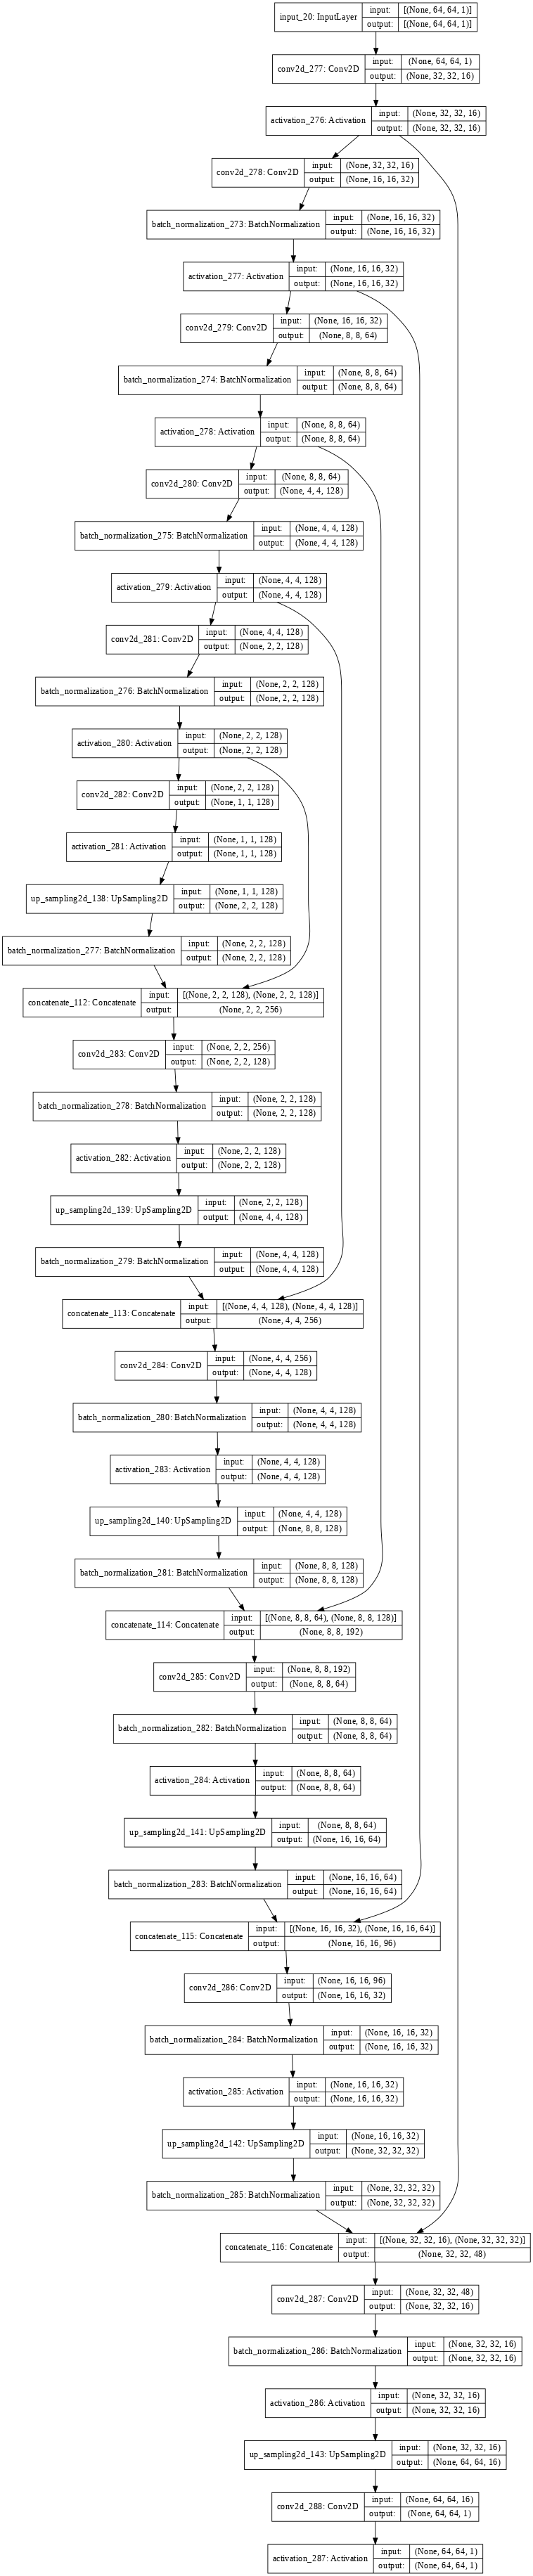

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [ ]:
print('* Training the compiled network *')
print()

history = model.fit(input_train, output_train, \
                    batch_size=batch_size, \
                    epochs=max_epochs, \
                    validation_split=validtrain_split_ratio, \
                    shuffle=batch_shuffle)

print()
print('Training completed')
print()

* Training the compiled network *

Epoch 1/20
32/32 [==============================] - 4s 44ms/step - loss: 0.1961 - mean_absolute_error: 0.1961 - val_loss: 0.1806 - val_mean_absolute_error: 0.1806
Epoch 2/20
32/32 [==============================] - 1s 22ms/step - loss: 0.1594 - mean_absolute_error: 0.1594 - val_loss: 0.1775 - val_mean_absolute_error: 0.1775
Epoch 3/20
32/32 [==============================] - 1s 22ms/step - loss: 0.1477 - mean_absolute_error: 0.1477 - val_loss: 0.1740 - val_mean_absolute_error: 0.1740
Epoch 4/20
32/32 [==============================] - 1s 22ms/step - loss: 0.1427 - mean_absolute_error: 0.1427 - val_loss: 0.1724 - val_mean_absolute_error: 0.1724
Epoch 5/20
32/32 [==============================] - 1s 22ms/step - loss: 0.1359 - mean_absolute_error: 0.1359 - val_loss: 0.1745 - val_mean_absolute_error: 0.1745
Epoch 6/20
32/32 [==============================] - 1s 22ms/step - loss: 0.1311 - mean_absolute_error: 0.1311 - val_loss: 0.1691 - val_mean_absolute_e

* plot example from test set

item_id :  3



ValueError: ignored

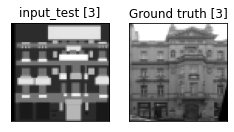

In [ ]:
for item_id in [3,8,19,56]:

  print('* plot example from test set')
  print()
  print('item_id : ', item_id)
  print()

  plt.subplot(1,3,1);plt.imshow(input_test[item_id],cmap='gray')
  plt.title('input_test [' + str(item_id) + ']')
  plt.grid(None)
  plt.xticks([])
  plt.yticks([])
  #plt.show()

  plt.subplot(1,3,2);plt.imshow(output_test[item_id],cmap='gray')
  plt.title('Ground truth [' + str(item_id) + ']')
  plt.grid(None)
  plt.xticks([])
  plt.yticks([])
  #plt.show()

  input_predict = np.zeros(shape=(64, 64,1))  # create numpy array of required dimensions for network input
  input_predict[:,:,0] = input_test[item_id]  # reshaping test input image
  output_predict = model.predict(input_predict)
  #print(np.shape(output_predict[0]))
  outimage=(output_predict[0])
  plt.subplot(1,3,3);plt.imshow((255*output_predict[0]).astype('uint8'))
  plt.title('Prediction [' + str(item_id) + ']')
  plt.grid(None)
  plt.xticks([])
  plt.yticks([])
  plt.show()